<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/NASDAQ%20return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NASDAQ Composite Price Analysis

What is NASDAQ Composite?

In [1]:
! pip install yfinance

     |████████████████████████████████| 6.3 MB 12.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=36ae98b67e7625fa049b389e9e3dfb345654c82ba9b790b32a48ea280d96747a
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import matplotlib.pyplot as plt
import yfinance as yf

In [13]:
df = yf.download('^IXIC',
start='2000-01-01',
end='2021-07-27',
progress=False)

In [14]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-20,14330.459961,14555.750000,14271.230469,14498.879883,14498.879883,4618980000
2021-07-21,14508.750000,14633.139648,14498.650391,14631.950195,14631.950195,4075150000
2021-07-22,14652.719727,14694.190430,14617.870117,14684.599609,14684.599609,3574560000
2021-07-23,14753.059570,14846.059570,14698.769531,14836.990234,14836.990234,3959410000
2021-07-26,14821.030273,14863.650391,14790.490234,14840.709961,14840.709961,4409960000


In [15]:
import pandas as pd
import numpy as np

In [16]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [18]:
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [19]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [29]:
df[['simple_rtn','log_rtn']].tail(20)

,simple_rtn,log_rtn
Date,,
2021-06-28,0.009757,0.009710
2021-06-29,0.001919,0.001917
2021-06-30,-0.001678,-0.001680
2021-07-01,0.001271,0.001270
2021-07-02,0.008053,0.008021
2021-07-06,0.001661,0.001659
2021-07-07,0.000097,0.000097
2021-07-08,-0.007179,-0.007205
2021-07-09,0.009762,0.009715


In [30]:
def realized_volatility(x):
   return np.sqrt(np.sum(x**2))

Calculate the monthly realized **volatility** * **

In [31]:
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)

In [32]:
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)

**Annualize the values:**

In [33]:
df_rv.rv = df_rv.rv * np.sqrt(12)

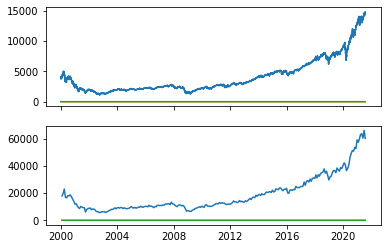

In [34]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[1].plot(df_rv)

[Text(0, 0.5, 'Log returns (%)'), Text(0.5, 0, 'Date')]

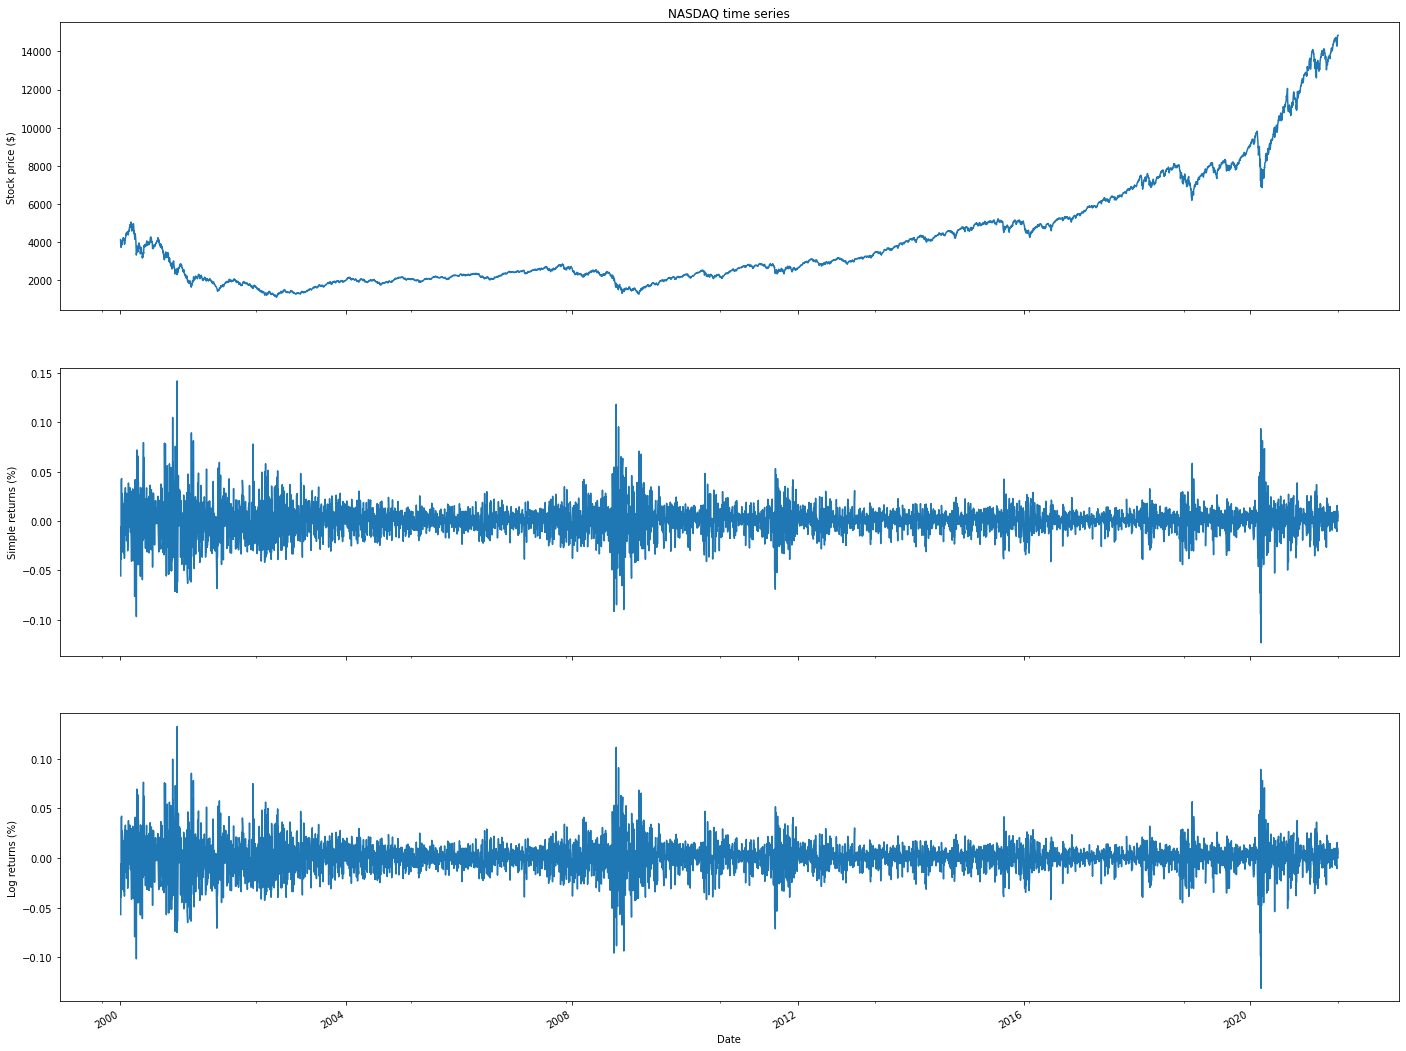

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'NASDAQ time series',
ylabel = 'Stock price ($)')
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date',
ylabel = 'Log returns (%)')

In [39]:
#Above each one of them presents a different series: 
#rawprices, simple returns, and log returns

In [44]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode


How to detect outliers using the 3σ approach, and mark them on a
plot.

In [45]:
df_rolling = df[['simple_rtn']].rolling(window=21) \
.agg(['mean', 'std'])

In [46]:
df_rolling.columns = df_rolling.columns.droplevel()

In [47]:
df_outliers = df.join(df_rolling)

In [67]:
def indentify_outliers(row, n_sigmas=3):
 x = row['simple_rtn']
 mu = row['mean']
 sigma = row['std']
 if (x > mu + 3*sigma)|(x < mu-3*sigma):
    return 1
 else:
  return 0


In [68]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,
axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,
['simple_rtn']]

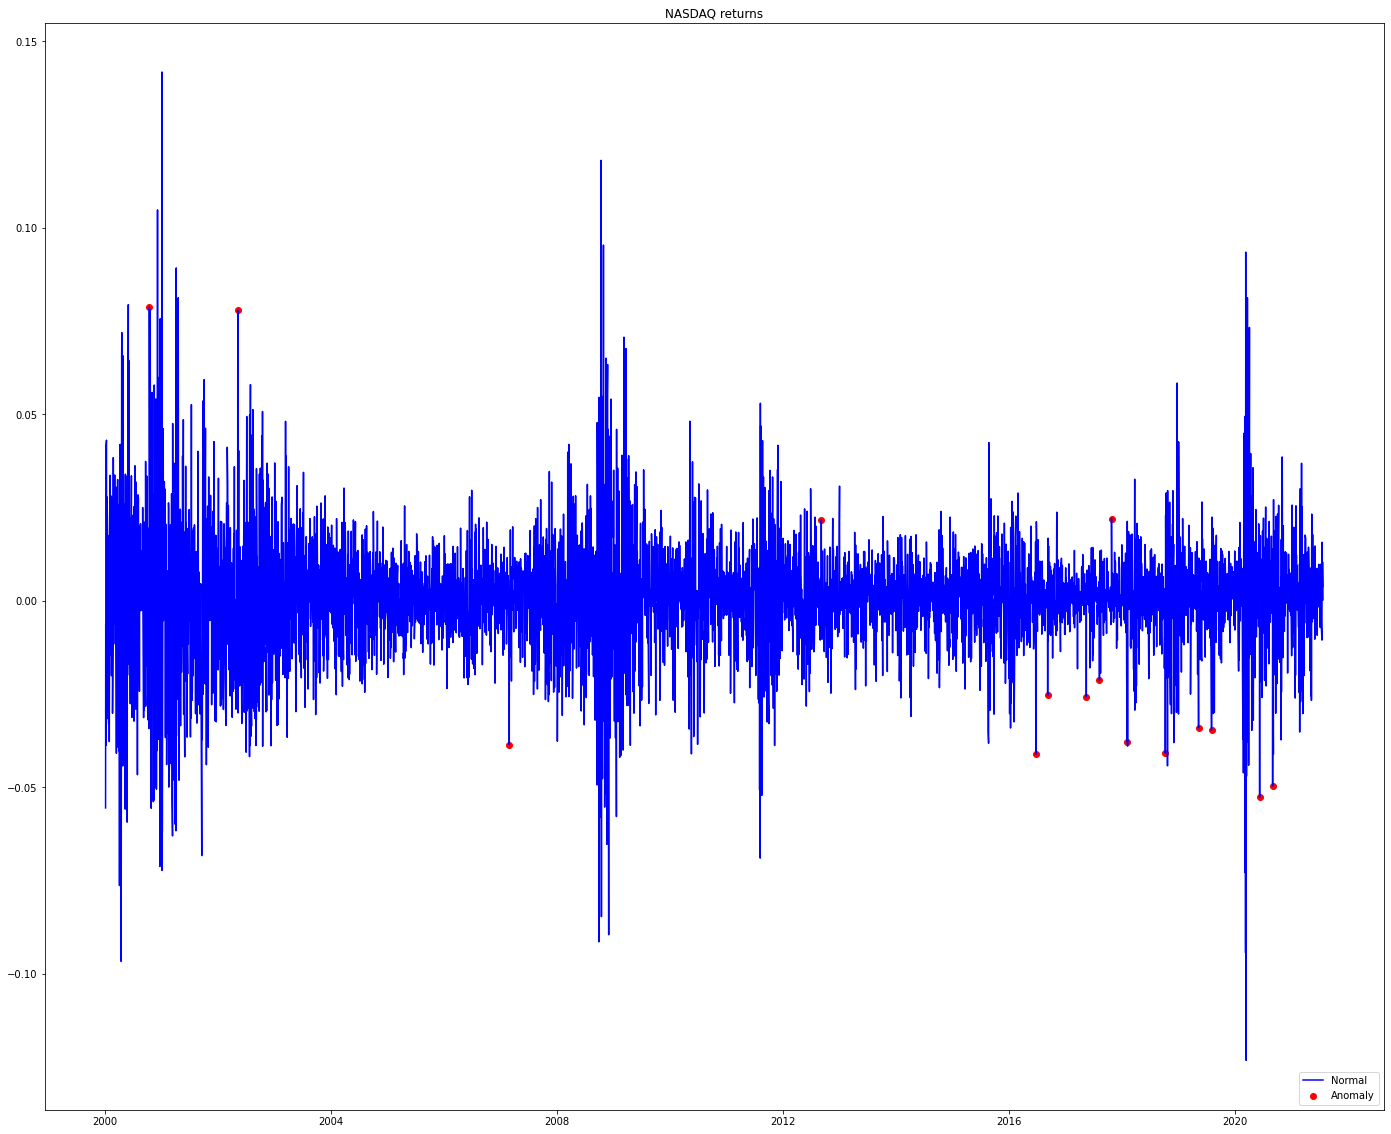

In [70]:
fig, ax = plt.subplots(figsize=(24, 20), sharex=True)
ax.plot(df_outliers.index, df_outliers.simple_rtn,
color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn,
color='red', label='Anomaly')
ax.set_title("NASDAQ returns")
ax.legend(loc='lower right')